In [110]:
import pandas as pd
import os
# read csv file for finger tapping labels
file_location = r'\\files.ubc.ca\team\PPRC\CAMERA\Booth_Processed\finger_tapping\docs\combined_v2.csv'
df_labels = pd.read_csv(file_location)
df_labels['Date'] = pd.to_datetime(df_labels['Date'], format='%d-%b-%y').dt.strftime('%Y%m%d')
df_labels.set_index(['ID','Date'], inplace=True)
#remove Collection_UPDRS_ from the column names
df_labels.columns = df_labels.columns.str.replace('Collection_UPDRS_', '')


df_right = df_labels[df_labels.columns[df_labels.columns.str.contains('Right', case=False)]]
df_left = df_labels[df_labels.columns[df_labels.columns.str.contains('Left', case=False)]]
df_right.columns = df_right.columns.str.replace('Right_', '')
df_left.columns = df_left.columns.str.replace('Left_', '')
df_right['hand'] = 'right'
df_left['hand'] = 'left'


df_union = pd.concat([df_right, df_left], axis=0)
#add hand to index 
df_union = df_union.reset_index()
df_union.set_index(df_union['ID'].astype(str) + '_' + df_union['Date'].astype(str) + '_' + df_union['hand'], inplace=True)
df_union.drop(columns=['ID','Date','hand'], inplace=True)

#numerical columns
df_union = df_union.apply(pd.to_numeric)
df_union['single'] = df_union['MG']
#apply majority vote to the columns
df_union['majority'] = df_union[['KW', 'MG', 'TM', 'SA','WM']].mode(axis=1)[0]

#drop all missing rows
df_union.dropna(axis=0, how='all', inplace=True)
def modify_string(s):
    parts = s.split('_')
    if len(parts) > 1 and parts[0].isdigit() and len(parts[0]) == 4:
        parts[0] = '0' + parts[0]
    return '_'.join(parts)

#add 0 to y index if it is split by _, firt part is 4 digit
df_union.index =df_union.index.map(modify_string)


C:\Users\atefe\AppData\Local\Temp\ipykernel_63796\3489792395.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_right['hand'] = 'right'
C:\Users\atefe\AppData\Local\Temp\ipykernel_63796\3489792395.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_left['hand'] = 'left'


In [117]:
#snorkel weak supervision
import pandas as pd
from snorkel.labeling.model.label_model import LabelModel 


# Constants
ABSTAIN = -1  # Use this if some of your LFs abstain

# Step 1: Create L matrix from the 5 LF columns
# Assume df_union columns are exactly the weak labels
L_train = df_union.fillna(ABSTAIN).iloc[:, :5].astype(float).values


# Step 2: Fit the Label Model
label_model = LabelModel(cardinality=5, verbose=True)  # change to 3 if multiclass
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)

# Step 3: Predict labels (hard and probabilistic)
df_union["snorkel_label"] = label_model.predict(L=L_train)
df_union["snorkel_prob_0"] = label_model.predict_proba(L=L_train)[:, 0]  # probability of class 0
df_union["snorkel_prob_1"] = label_model.predict_proba(L=L_train)[:, 1]  # probability of class 1
df_union["snorkel_prob_2"] = label_model.predict_proba(L=L_train)[:, 2]  # probability of class 2
df_union["snorkel_prob_3"] = label_model.predict_proba(L=L_train)[:, 3]  # probability of class 3
df_union["snorkel_prob_4"] = label_model.predict_proba(L=L_train)[:, 4]  # probability of class 4

# df_union.reset_index(inplace=True)
# df_union.rename(columns={'index': 'ID'}, inplace=True)
#df_union.to_csv(r'\\files.ubc.ca\team\PPRC\CAMERA\Booth_Processed\finger_tapping\docs\weak_supervision.csv', index=False)

INFO:root:Computing O...
INFO:root:Estimating \mu...
100%|██████████| 500/500 [00:00<00:00, 1001.04epoch/s]
INFO:root:Finished Training


In [ ]:
#combine L_file wth classifier and severiy score
import pandas as pd
import numpy as np


df_severity = pd.read_csv(r'\\files.ubc.ca\team\PPRC\Camera\Booth_Results\finger_tapping_ws\Experiment2\csvs\predicted_labels_severity.csv')
df_classifier = pd.read_csv('complete_predicted_labels_loocv.csv').set_index('File_Name')
df_L = df_union.copy()
#drop duplicate file_name where other values are not available
df_L.drop_duplicates(subset='file_name', inplace=True)
df_L = df_L.set_index('file_name')

df_L['classifier'] = df_classifier['Predicted_Label']
df_severity['file_name'] = df_severity['Patient_ID']+'_finger_tapping_distances.csv'
df_severity = df_severity.drop(columns=['Patient_ID']).set_index('file_name')

df_L = df_L.join(df_severity)
df_L.rename(columns={'Predicted_Label':'severity model'}, inplace=True)
df_L['severity model'] = df_L['severity model'].round(0)
# df_L.to_csv(L_file, index=True)

In [112]:
#train random forest classifier
import numpy as np
import pandas as pd
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_absolute_error, mean_squared_error
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
import joblib
from tqdm import tqdm

# Load the data
file_l = r'\\files.ubc.ca\team\PPRC\Camera\Booth_Results\finger_tapping_ws\Experiment2\csvs\left_features_extracted_finger_distance.csv'
file_r = r'\\files.ubc.ca\team\PPRC\Camera\Booth_Results\finger_tapping_ws\Experiment2\csvs\right_features_extracted_finger_distance.csv'
df_l_r = pd.concat([pd.read_csv(file_l), pd.read_csv(file_r)])
file1 = r'\\files.ubc.ca\team\PPRC\CAMERA\Booth_Processed\finger_tapping\docs\weak_supervision.csv'
df_updrs = pd.read_csv(file1)[['ID','snorkel_label']]
df_updrs.rename(columns={'snorkel_label':'UPDRS'}, inplace=True)
df_l_r['ID'] = df_l_r['file_name'].str.split('_finger').str[0]
df_l_r.drop(columns=['file_name'], inplace=True)

df = pd.merge(df_l_r, df_updrs, on='ID', how='left')
df = df.dropna(subset=['UPDRS'])

# Define the features and target
X = df.drop(columns=['ID', 'UPDRS'])
y = df['UPDRS']
X.fillna(0, inplace=True)
file_names = df['ID']

# Feature selection
selector = SelectKBest(score_func=f_classif, k=20)
selector.fit(X, y)
X_selected = selector.transform(X)

# Initialize the leave-one-out cross-validator
loo = LeaveOneOut()
smote = SMOTE( random_state=42)

# Initialize lists to store results
all_preds = []
all_labels = []
all_file_names = []

# Loop over each split
for train_index, test_index in tqdm(loo.split(X_selected)):
    X_train, X_test = X_selected[train_index], X_selected[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    file_name_test = file_names.iloc[test_index].values[0]
    
    # Apply SMOTE to the training data
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Initialize and train the classifier
    clf = RandomForestClassifier(random_state=42, n_estimators=500, max_depth=12)
    clf.fit(X_train_resampled, y_train_resampled)

    # Make prediction for the test instance
    y_pred = clf.predict(X_test)

    # Store the results
    all_preds.append(y_pred[0])
    all_labels.append(y_test.values[0])
    all_file_names.append(file_name_test)

# Evaluate the classifier
print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))
print("\nAccuracy Score:")
print(accuracy_score(all_labels, all_preds))

# Calculate and print MAE and MSE
mae = mean_absolute_error(all_labels, all_preds)
mse = mean_squared_error(all_labels, all_preds)
print(f"\nMean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")

# Save the model, feature selector, and predictions
#joblib.dump(clf, 'rf_model.pkl')
#joblib.dump(selector, 'feature_selector.pkl')

results_df = pd.DataFrame({
    'File_Name': all_file_names,
    'True_Label': all_labels,
    'Predicted_Label': all_preds
})

# Identify rows in df_l_r not in results_df and predict their labels
unprocessed_files = df_l_r[~df_l_r['ID'].isin(results_df['File_Name'])]

if not unprocessed_files.empty:
    unprocessed_X = unprocessed_files.drop(columns=['ID'])
    unprocessed_X = unprocessed_X[X.columns]
    unprocessed_X.fillna(0, inplace=True)

    # Apply the same scaling and transformation
    unprocessed_X_selected = selector.transform(unprocessed_X)
    unprocessed_preds = clf.predict(unprocessed_X_selected)

    unprocessed_results_df = pd.DataFrame({
        'File_Name': unprocessed_files['ID'],
        'True_Label': np.nan,  # True labels are not available for these
        'Predicted_Label': unprocessed_preds
    })

    # Add these predictions to the original results_df
    results_df = pd.concat([results_df, unprocessed_results_df], ignore_index=True)

# Save all results to a CSV file
#results_df.to_csv('complete_predicted_labels_loocv.csv', index=False)

print("Model, feature selector, and all predicted labels saved successfully.")
#merge df results df to the union df
df_union = df_union.join(results_df.set_index('File_Name')['Predicted_Label'])
df_union.rename(columns={'Predicted_Label':'RF'}, inplace=True) 

c:\Users\atefe\.conda\envs\assessment\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [19] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\atefe\.conda\envs\assessment\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
433it [08:29,  1.18s/it]

Confusion Matrix:
[[48 21 11  2  0]
 [18 38 26 10  4]
 [ 7 22 39 28  3]
 [ 3 11 25 68 13]
 [ 1  3  2 16 14]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.62      0.59      0.60        82
         1.0       0.40      0.40      0.40        96
         2.0       0.38      0.39      0.39        99
         3.0       0.55      0.57      0.56       120
         4.0       0.41      0.39      0.40        36

    accuracy                           0.48       433
   macro avg       0.47      0.47      0.47       433
weighted avg       0.48      0.48      0.48       433


Accuracy Score:
0.4780600461893764

Mean Absolute Error (MAE): 0.6859122401847575
Mean Squared Error (MSE): 1.0831408775981524
Model, feature selector, and all predicted labels saved successfully.


In [111]:

#merge with lightgbm model
df_severity = pd.read_csv(r'\\files.ubc.ca\team\PPRC\CAMERA\Booth_Processed\finger_tapping\docs\labels_updrs_weak_severity_model.csv')
df_severity['filename'] = df_severity['filename'].str.replace('_finger_tapping.mp4', '')
df_severity.set_index('filename', inplace=True)

#join the severity model to the df_union
df_union = df_union.join(df_severity['Predicted_Label'],)
df_union.rename(columns={'Predicted_Label':'LightGBM'}, inplace=True)
df_union['LightGBM'] = df_union['LightGBM'].round(0)

In [114]:
#snorkel model for combine all
#snorkel weak supervision
import pandas as pd
from snorkel.labeling.model.label_model import LabelModel 


# Constants
ABSTAIN = -1  # Use this if some of your LFs abstain

# Step 1: Create L matrix from the 5 LF columns
# Assume df_union columns are exactly the weak labels
L_train = df_union.fillna(ABSTAIN)[['KW','MG','SA','TM','WM','LightGBM','RF']].astype(float).values


# Step 2: Fit the Label Model
label_model = LabelModel(cardinality=5, verbose=True)  # change to 3 if multiclass
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)

# Step 3: Predict labels (hard and probabilistic)
df_union["snorkel_label_final"] = label_model.predict(L=L_train)
df_union["snorkel_prob_0_final"] = label_model.predict_proba(L=L_train)[:, 0]  # probability of class 0
df_union["snorkel_prob_1_final"] = label_model.predict_proba(L=L_train)[:, 1]  # probability of class 1
df_union["snorkel_prob_2_final"] = label_model.predict_proba(L=L_train)[:, 2]  # probability of class 2
df_union["snorkel_prob_3_final"] = label_model.predict_proba(L=L_train)[:, 3]  # probability of class 3
df_union["snorkel_prob_4_final"] = label_model.predict_proba(L=L_train)[:, 4]  # probability of class 4

df_union.to_csv(r'\\files.ubc.ca\team\PPRC\CAMERA\Booth_Processed\finger_tapping\docs\weak_supervision_final.csv', index=True)

INFO:root:Computing O...
INFO:root:Estimating \mu...
100%|██████████| 500/500 [00:00<00:00, 677.66epoch/s]
INFO:root:Finished Training


In [3]:
#train random forest classifier
import numpy as np
import pandas as pd
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_absolute_error, mean_squared_error
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
import joblib
from tqdm import tqdm

# Load the data
file_l = r'\\files.ubc.ca\team\PPRC\Camera\Booth_Results\finger_tapping_ws\Experiment2\csvs\left_features_extracted_finger_distance.csv'
file_r = r'\\files.ubc.ca\team\PPRC\Camera\Booth_Results\finger_tapping_ws\Experiment2\csvs\right_features_extracted_finger_distance.csv'
df_l_r = pd.concat([pd.read_csv(file_l), pd.read_csv(file_r)])
file1 = r'\\files.ubc.ca\team\PPRC\CAMERA\Booth_Processed\finger_tapping\docs\weak_supervision.csv'
df_updrs = pd.read_csv(file1)[['ID','snorkel_label']]
df_updrs.rename(columns={'snorkel_label':'UPDRS'}, inplace=True)
df_l_r['ID'] = df_l_r['file_name'].str.split('_finger').str[0]
df_l_r.drop(columns=['file_name'], inplace=True)

df = pd.merge(df_l_r, df_updrs, on='ID', how='left')
df = df.dropna(subset=['UPDRS'])

# Define the features and target
X = df.drop(columns=['ID', 'UPDRS'])
y = df['UPDRS']
X.fillna(0, inplace=True)
file_names = df['ID']

# Feature selection
selector = SelectKBest(score_func=f_classif, k=20)
selector.fit(X, y)
X_selected = selector.transform(X)

# Initialize the leave-one-out cross-validator
loo = LeaveOneOut()
smote = SMOTE( random_state=42)

# Initialize lists to store results
all_preds = []
all_labels = []
all_file_names = []

# Loop over each split
for train_index, test_index in tqdm(loo.split(X_selected)):
    X_train, X_test = X_selected[train_index], X_selected[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    file_name_test = file_names.iloc[test_index].values[0]
    
    # Apply SMOTE to the training data
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Initialize and train the classifier
    clf = RandomForestClassifier(random_state=42, n_estimators=500, max_depth=12)
    clf.fit(X_train_resampled, y_train_resampled)

    # Make prediction for the test instance
    y_pred = clf.predict(X_test)

    # Store the results
    all_preds.append(y_pred[0])
    all_labels.append(y_test.values[0])
    all_file_names.append(file_name_test)

# Evaluate the classifier
print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))
print("\nAccuracy Score:")
print(accuracy_score(all_labels, all_preds))

# Calculate and print MAE and MSE
mae = mean_absolute_error(all_labels, all_preds)
mse = mean_squared_error(all_labels, all_preds)
print(f"\nMean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")

# Save the model, feature selector, and predictions
#joblib.dump(clf, 'rf_model.pkl')
#joblib.dump(selector, 'feature_selector.pkl')

results_df = pd.DataFrame({
    'File_Name': all_file_names,
    'True_Label': all_labels,
    'Predicted_Label': all_preds
})

# Identify rows in df_l_r not in results_df and predict their labels
unprocessed_files = df_l_r[~df_l_r['ID'].isin(results_df['File_Name'])]

if not unprocessed_files.empty:
    unprocessed_X = unprocessed_files.drop(columns=['ID'])
    unprocessed_X = unprocessed_X[X.columns]
    unprocessed_X.fillna(0, inplace=True)

    # Apply the same scaling and transformation
    unprocessed_X_selected = selector.transform(unprocessed_X)
    unprocessed_preds = clf.predict(unprocessed_X_selected)

    unprocessed_results_df = pd.DataFrame({
        'File_Name': unprocessed_files['ID'],
        'True_Label': np.nan,  # True labels are not available for these
        'Predicted_Label': unprocessed_preds
    })

    # Add these predictions to the original results_df
    results_df = pd.concat([results_df, unprocessed_results_df], ignore_index=True)

# Save all results to a CSV file
#results_df.to_csv('complete_predicted_labels_loocv.csv', index=False)

print("Model, feature selector, and all predicted labels saved successfully.")

c:\Users\atefe\.conda\envs\assessment\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [19] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\atefe\.conda\envs\assessment\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
433it [09:34,  1.33s/it]

Confusion Matrix:
[[48 21 11  2  0]
 [18 38 26 10  4]
 [ 7 22 39 28  3]
 [ 3 11 25 68 13]
 [ 1  3  2 16 14]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.62      0.59      0.60        82
         1.0       0.40      0.40      0.40        96
         2.0       0.38      0.39      0.39        99
         3.0       0.55      0.57      0.56       120
         4.0       0.41      0.39      0.40        36

    accuracy                           0.48       433
   macro avg       0.47      0.47      0.47       433
weighted avg       0.48      0.48      0.48       433


Accuracy Score:
0.4780600461893764

Mean Absolute Error (MAE): 0.6859122401847575
Mean Squared Error (MSE): 1.0831408775981524
Model, feature selector, and all predicted labels saved successfully.



--- Inter-Rater Standard Deviation per UPDRS Class ---
Class 0: 0.5384
Class 1: 1.0451
Class 2: 0.6253
Class 3: 0.6681
Class 4: 0.5224

--- HiLWS Entropy (Uncertainty) per UPDRS Class ---
Class 0: 0.2842
Class 1: 0.5697
Class 2: 0.5082
Class 3: 0.3767
Class 4: 0.1587

--- QWK Between Raters and HiLWS ---
KW: 0.7885
MG: 0.8122
TM: 0.6470
SA: 0.7371
WM: 0.6491

--- QWK Between Rater Pairs ---
KW                     float64
MG                     float64
TM                     float64
SA                     float64
WM                     float64
snorkel_label_final      int32
dtype: object


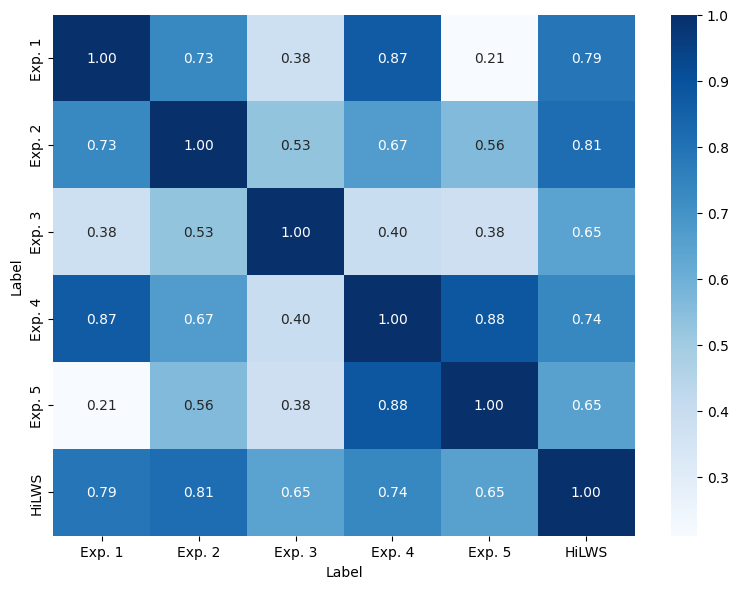

In [120]:
#Compute paper metrics
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
from sklearn.metrics import cohen_kappa_score

import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, cohen_kappa_score, f1_score, mean_absolute_error
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Define raters and probability columns
raters = ['KW', 'MG', 'TM', 'SA', 'WM']
prob_cols = [f"snorkel_prob_{i}" for i in range(5)]

# 1. Inter-Rater Std. Dev and Entropy per Class
inter_rater_std = {}
entropy_scores = {}

for c in range(5):
    class_group = df_union[df_union['snorkel_label'] == c]
    if not class_group.empty:
        inter_rater_std[c] = class_group[raters].std(axis=1).mean()
        probs = class_group[prob_cols].values
        entropy_scores[c] = np.mean([entropy(p) for p in probs])
    else:
        inter_rater_std[c] = np.nan
        entropy_scores[c] = np.nan

print("\n--- Inter-Rater Standard Deviation per UPDRS Class ---")
for c in range(5):
    print(f"Class {c}: {inter_rater_std[c]:.4f}")

print("\n--- HiLWS Entropy (Uncertainty) per UPDRS Class ---")
for c in range(5):
    print(f"Class {c}: {entropy_scores[c]:.4f}")


# 3. QWK Between Each Rater and HiLWS

print("\n--- QWK Between Raters and HiLWS ---")
for r in raters:
    mask = df_union[[r, 'snorkel_label_final']].dropna().index
    qwk = cohen_kappa_score(df_union.loc[mask, r], df_union.loc[mask, 'snorkel_label_final'], weights='quadratic')
    print(f"{r}: {qwk:.4f}")

# 4. QWK Between All Rater Pairs
print("\n--- QWK Between Rater Pairs ---")
raters = ['KW', 'MG', 'TM', 'SA', 'WM','snorkel_label_final']
print(df_union[raters].dtypes)
qwk_matrix = np.zeros((len(raters), len(raters)))

for i, r1 in enumerate(raters):
    for j, r2 in enumerate(raters):
        mask = df_union[[r1, r2]].dropna().index
        matching_rows = df_union.loc[mask,:]
        if i == j:
            qwk_matrix[i][j] = 1.0
        else:
            qwk_matrix[i][j] = cohen_kappa_score(matching_rows[r1], matching_rows[r2], weights='quadratic')

# Plot the QWK matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(qwk_matrix, annot=True, xticklabels=['Exp. 1','Exp. 2','Exp. 3','Exp. 4','Exp. 5','HiLWS'], yticklabels=['Exp. 1','Exp. 2','Exp. 3','Exp. 4','Exp. 5','HiLWS'], cmap='Blues', fmt=".2f" )
# set font size
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
#plt.title("Quadratic Weighted Kappa Between Raters")
plt.xlabel("Label")
plt.ylabel("Label")
plt.tight_layout()
plt.show()



In [ ]:

# Store the results
all_preds.append(y_pred[0])
all_labels.append(y_test.values[0])
all_file_names.append(file_name_test)

# Evaluate the classifier
print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))
print("\nAccuracy Score:")
print(accuracy_score(all_labels, all_preds))

# Calculate and print MAE and MSE
mae = mean_absolute_error(all_labels, all_preds)
mse = mean_squared_error(all_labels, all_preds)
print(f"\nMean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")

# Save the model, feature selector, and predictions
#joblib.dump(clf, 'rf_model.pkl')
#joblib.dump(selector, 'feature_selector.pkl')

results_df = pd.DataFrame({
    'File_Name': all_file_names,
    'True_Label': all_labels,
    'Predicted_Label': all_preds
})

# Identify rows in df_l_r not in results_df and predict their labels
unprocessed_files = df_l_r[~df_l_r['ID'].isin(results_df['File_Name'])]

if not unprocessed_files.empty:
    unprocessed_X = unprocessed_files.drop(columns=['ID'])
    unprocessed_X = unprocessed_X[X.columns]
    unprocessed_X.fillna(0, inplace=True)

    # Apply the same scaling and transformation
    unprocessed_X_selected = selector.transform(unprocessed_X)
    unprocessed_preds = clf.predict(unprocessed_X_selected)

    unprocessed_results_df = pd.DataFrame({
        'File_Name': unprocessed_files['ID'],
        'True_Label': np.nan,  # True labels are not available for these
        'Predicted_Label': unprocessed_preds
    })

    # Add these predictions to the original results_df
    results_df = pd.concat([results_df, unprocessed_results_df], ignore_index=True)

# Save all results to a CSV file
#results_df.to_csv('complete_predicted_labels_loocv.csv', index=False)

print("Model, feature selector, and all predicted labels saved successfully.")